# Vectorizing backpropagation (in practice)

We've {ref}`already seen vectorized computational graphs in action <chapter:tensors/mlp>`, where we used layers of the form

$$
\tanh \big( X A \big), \quad X \in \mathbb{R}^{N \times n}, \quad A \in \mathbb{R}^{n \times m},
$$

where $ X \in \mathbb{R}^{N \times n} $ is the data matrix, and $ A \in \mathbb{R}^{n \times m} $ is the parameter matrix. In other words: vectorization is not enough; we need to *tensorize*. (There's no such term as tensorize, I just made that one up.)

Let's look at matrix addition: for any $ X, Y \in \mathbb{R}^{n \times m} $, their sum $ Z = X + Y \in \mathbb{R}^{n \times m} $ defines the familiar V-shaped graph:

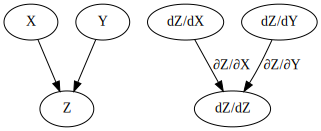

In [1]:
from graphviz import Digraph

digraph = Digraph()

nodes = ["X", "Y", "Z"]
edges = [("X", "Z"), ("Y", "Z")]
offset = " "

for v in nodes:
    digraph.node(v)
    digraph.node(v + offset, f"dZ/d{v}")

for u, v in edges:
    digraph.edge(u, v)
    digraph.edge(u + offset, v + offset, f"∂{v}/∂{u}")

digraph

What do $ \frac{dX}{dY} $ and $ \frac{\partial X}{\partial Y} $ mean?

Uh-oh. We have a snag. Following the logic of the Jacobian, these should be four-dimensional *tensors*:

$$
\begin{align*}
\frac{dX}{dY} &= \bigg( \frac{dx_{i,j}}{dy_{k, l}} \bigg)_{i, j, k, l = 1, \dots, n} \in \mathbb{R}^{n \times n \times n \times n}, \\
\frac{\partial X}{\partial Y} &= \bigg( \frac{\partial x_{i,j}}{\partial y_{k, l}} \bigg)_{i, j, k, l = 1, \dots, n} \in \mathbb{R}^{n \times n \times n \times n}.
\end{align*}
$$

How do we multiply tensors?

We don't. Rather than spending blood, sweat, and tears to figuring out how multidimensional matrices (a.k.a. tensors) are multiplied, we circumvent the problem.

## Computational graphs in practice

Fortunately, we can completely avoid working with matrix-matrix derivatives by noticing that the terminal node of our computational graphs in training is always a scalar: the loss function!

Take a look at multivariate linear regression:

$$
    \mathbf{p} = X A,
$$

where $ X \in \mathbb{R}^{N \times n} $ represents the data, $ A \in \mathbb{R}^{n \times m} $ encodes the parameters, and $ \mathbf{p} \in \mathbb{R}^{N \times m} $ contains the predictions. (Note that we have omitted the bias for simplicity; you can assume that the bias is included in $ A $ and $ X $ is augmented with a row of ones.)

With these in mind, the loss is defined by

$$
l = \frac{1}{N} \mathrm{sum}\Big( (\mathbf{y} - \mathbf{p})^2 \Big),
$$

where

* $ \mathbf{y} \in \mathbb{R}^{N \times m} $ is the ground truth,
* $ \mathbf{y} - \mathbf{p} $ is the *pointwise difference* of the two matrices,
* $ (\mathbf{y} - \mathbf{p})^2 $ is the pointwise square of $ \mathbf{y} - \mathbf{p} $,
* and $ \mathrm{sum} \Big( (\mathbf{y} - \mathbf{p})^2 \Big) $ is the sum of the elements of $ (\mathbf{y} - \mathbf{p})^2 $.

All in all, $ l $ is a scalar! Here's the computational graph and its derivative:

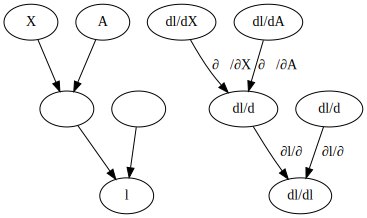

In [2]:
digraph = Digraph()

nodes = ["X", "A", "𝐩", "𝐲", "l"]
edges = [("X", "𝐩"), ("A", "𝐩"), ("𝐩", "l"), ("𝐲", "l")]
offset = " "

for v in nodes:
    digraph.node(v)
    digraph.node(v + offset, f"dl/d{v}")

for u, v in edges:
    digraph.edge(u, v)
    digraph.edge(u + offset, v + offset, f"∂{v}/∂{u}")


digraph

Look at the global derivatives: as the loss $ l \in \mathbb{R} $ is a scalar, global derivatives are all matrices: $ \frac{dl}{dX} \in \mathbb{R}^{N \times n} $, $ \frac{dl}{dA} \in \mathbb{R}^{n \times m} $, $ \frac{dl}{d\mathbf{p}} \in \mathbb{R}^{n \times 1} $, $ \frac{dl}{d\mathbf{y}} \in \mathbb{R}^{n \times 1} $, and $ \frac{dl}{dl} \in \mathbb{R} $.

In other words, if the terminal node is a scalar, the global derivative of a node has the exact same shape as the node itself.

We cut off one head of the dragon, but what about the other? The local derivatives are still out of control: $ \frac{\partial \mathbf{p}}{\partial X} \in \mathbb{R}^{N \times N \times n} $ and $ \frac{\partial \mathbf{p}}{\partial X} \in \mathbb{R}^{N \times n \times m} $. Let's take a detailed look at what happens along the single edge $ X \to \mathbf{p} $. Hell, let's even write this out componentwise:

$$
\begin{bmatrix}
x_{1, 1} & x_{1, 2} & \dots & x_{1, n} \\
x_{2, 1} & x_{2, 2} & \dots & x_{2, n} \\
\vdots & \vdots & \ddots & \vdots \\
x_{N, 1} & x_{N, 2} & \dots & x_{N, n} \\
\end{bmatrix} \mapsto \begin{bmatrix}
p_{1, 1} & p_{1, 2} & \dots & p_{1, m} \\
p_{2, 1} & p_{2, 2} & \dots & p_{2, m} \\
\vdots & \vdots & \ddots & \vdots \\
p_{N, 1} & p_{N, 2} & \dots & p_{N, m} \\
\end{bmatrix}
$$

You can think about a $ p_{i, j} $ as the function of the elements of $ X $. We don't explicitly indicate this, but it's important.

During backpropagation, we take a step in the opposite direction, mapping the global derivative $ \frac{dl}{d\mathbf{p}} $ to $ \frac{dl}{dX} $:

$$
\begin{bmatrix}
\frac{dl}{dp_{1, 1}} & \frac{dl}{dp_{1, 2}} & \dots & \frac{dl}{dp_{1, m}} \\
\frac{dl}{dp_{2, 1}} & \frac{dl}{dp_{2, 2}} & \dots & \frac{dl}{dp_{2, m}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{dl}{dp_{N, 1}} & \frac{dl}{dp_{N, 2}} & \dots & \frac{dl}{dp_{N, m}} \\
\end{bmatrix} \mapsto \begin{bmatrix}
\frac{dl}{dx_{1, 1}} & \frac{dl}{dx_{1, 2}} & \dots & \frac{dl}{dx_{1, n}} \\
\frac{dl}{dx_{2, 1}} & \frac{dl}{dx_{2, 2}} & \dots & \frac{dl}{dx_{2, n}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{dl}{dx_{N, 1}} & \frac{dl}{dx_{N, 2}} & \dots & \frac{dl}{dx_{N, n}} \\
\end{bmatrix}.
$$

I know. That's a lot of derivatives. With the scalar version of the chain rule, we can express every single element of $ \frac{dy}{dX} $ by

$$
\frac{dl}{dx_{i, j}} = \sum_{k = 1}^{N} \sum_{l = 1}^{m} \frac{dl}{dp_{k, l}} \frac{\partial p_{k, l}}{\partial x_{i, j}}.
$$ (eq:tensors/vectorizing-backpropagation/full-chain-rule)

Again, that's a lot of indices. Think of $ i $ and $ j $ as fixed, while $ k $ and $ l $ runs through all possible values.

Bad news: we won't always be able to describe the backwards step with a compact linear algebraic expression. Good news: in practice, most $ \frac{\partial p_{k, l}}{\partial x_{i, j}} $ values are zero! So, {eq}`eq:tensors/vectorizing-backpropagation/full-chain-rule` will always be simplified.

We'll walk through all of the operations: addition, multiplication, broadcasting, reshaping, and many more.

## Arithmetic operations

Unlike for `Scalar`s, we'll implement the backwards step differently for each operation. How can we solve this?

Our plan is to
* enhance the `Edge` class to handle the custom backwards functions,
* and update the `_backward_step` to call that function.

Let's go. We'll do the `Edge`. first. As it is a `namedtuple`, this is as simple as adding a new `backward_fn` attribute, in which we'll store a callable.

In [3]:
from collections import namedtuple


Edge = namedtuple(
    "Edge", ["prev", "local_grad", "backward_fn"], defaults=[None, None, None]
)

(We've added `None` as default values. This will be useful later.)

`backward_fn` gives us infinite freedom in our implementation, so let's agree to only use functions that take three arguments: 
* `tensor`, the `Tensor` from which the backward step is called,
* `local_grad`, the local gradient of the step,
* and `prev`, the `Tensor` whose backward gradient is being calculated.

Here's what it looks like in code.

In [4]:
import numpy as np


def typical_backward_fn(tensor, local_grad, prev):
    """
    Computes the backward gradient for the given tensor.

    Parameters
    ----------
    tensor : Tensor
        The tensor from which the backward step is performed.
    local_grad : Tensor
        The local gradient at the current layer.
    prev : Tensor
        The tensor to which the backward gradient will be propagated.
    """
    
    return 42

Now, the `Tensor`. This is the first time we are looking into its internals. Here we go:

In [5]:
import numpy as np
from typing import List


class Tensor:
    def __init__(
        self,
        value: np.ndarray,
        prevs: List = None,
    ):
        self.value = np.array(value)
        self.prevs = prevs if prevs is not None else []
        self.backwards_grad = np.zeros_like(value)

    def __repr__(self):
        return self.value.__repr__().replace("array", "Tensor")

    def _backward_step(self):
        for prev, local_grad, backward_fn in self.prevs:
            prev.backwards_grad += backward_fn(self, local_grad, prev)

    def _get_graph(self, zero_grad=False):
        ordered_tensors = []
        visited_tensors = set()

        def traverse_graph(x):
            if x not in visited_tensors:
                visited_tensors.add(x)

                if zero_grad:
                    x.backwards_grad = 0

                for prev, _, _ in x.prevs:
                    traverse_graph(prev)

                ordered_tensors.append(x)

        traverse_graph(self)

        return ordered_tensors

    def _zero_grad(self):
        self._get_graph(zero_grad=True)

    def gradient_update(self, lr):
        self.value -= lr * self.backwards_grad

    def backward(self, zero_grad=True):
        ordered_tensors = self._get_graph(zero_grad=zero_grad)

        self.backwards_grad = np.ones_like(self.value)

        for tensor in reversed(ordered_tensors):
            tensor._backward_step()


Notice `Tensor.value` is a NumPy array. (Unlike `Scalar.value`, which is a vanilla number type.) Also check out `_backward_step`: instead of incrementing by the product of `backwards_grad` and `local_grad`, we call the `backward_fn`.

Let's look at an example so we can actually understand this. As usual, we start with the simplest one: the addition.

### Addition

We've seen this thousands of times: for any two matrices $ X, Y \in \mathbb{R}^{n \times m} $, their sum is defined by

$$
Z = X + Y = \begin{bmatrix}
x_{1, 1} + y_{1, 1} & x_{1, 2} + y_{1, 2} & \dots & x_{1, m} + y_{1, m} \\
x_{2, 1} + y_{2, 1} & x_{2, 2} + y_{2, 2} & \dots & x_{1, m} + y_{1, m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n, 1} + y_{n, 1} & x_{n, 2} + y_{n, 2} & \dots & x_{n, m} + y_{n, m} \\
\end{bmatrix}.
$$

Matrices are added elementwise, nothing special about that. 

Suppose that there's a loss $ l \in \mathbb{R} $ down the line, and we are launching our backpropagation from that node. We can calculate the partial derivatives $ \frac{\partial z_{k, l}}{\partial x_{i, j}} $ easily. The expression {eq}`eq:tensors/vectorizing-backpropagation/full-chain-rule` might scare you, but most terms are zeros:

$$
\begin{align*}
\frac{dl}{dx_{i, j}} &= \sum_{k = 1}^{N} \sum_{l = 1}^{m} \frac{dl}{dz_{k, l}} \frac{\partial z_{k, l}}{\partial x_{i, j}} = \frac{dl}{dz_{i, j}},
\end{align*}
$$

as because of $ z_{k, l} = x_{k, l} + y_{k, l} $, 

$$

\frac{\partial z_{k, l}}{\partial x_{i, j}} = \begin{cases}
1 & \text{if } i = k \text{ and } l = j, \\
0 & \text{otherwise.}
\end{cases}
$$

Similarly, $ \frac{dl}{dy_{i, j}} = \frac{dl}{dz_{i, j}} $.

How do we implement this? In a sense, we can "collapse" the four-dimensional tensor that is the local derivative into a matrix of ones; while the backwards function simply multiplies the backwards gradient elementwise with it. (Or in other words, it does nothing.) Let's call it `_pointwise`, which you can find it at `mlfz.nn.tensor.utils`.

In [6]:
def _pointwise(tensor, local_grad, prev):
    """
    Accumulation of the backwards gradient via pointwise multiplication.
    """
    
    return tensor.backwards_grad * local_grad

Now, let's see that `Tensor.__add__`.

In [7]:
class Tensor(Tensor):
    # ...

    def __add__(self, other):
        """
        Pointwise addition of tensors.
        """
        
        if not isinstance(other, Tensor):
            other = Tensor(other)

        return Tensor(
            value=self.value + other.value,
            prevs=[
                Edge(prev=self, local_grad=np.ones_like(self), backward_fn=_pointwise),
                Edge(prev=other, local_grad=np.ones_like(other), backward_fn=_pointwise),
            ],
        )
    
    # ...

(I know, we could have defined a backwards function that simply copies the backwards gradient, but I decided to go with `_pointwise`. We'll reuse this in a hot minute.)

Let's test it out.

In [8]:
X = Tensor(2*np.ones((3, 4)))
Y = Tensor(3*np.ones((3, 4)))

In [9]:
Z = X + Y

In [10]:
Z

Tensor([[5., 5., 5., 5.],
       [5., 5., 5., 5.],
       [5., 5., 5., 5.]])

Let's check the backwards gradients.

In [11]:
Z.backward()

In [12]:
X.backwards_grad

array([[1.0, 1.0, 1.0, 1.0],
       [1.0, 1.0, 1.0, 1.0],
       [1.0, 1.0, 1.0, 1.0]], dtype=object)

In [13]:
Y.backwards_grad

array([[1.0, 1.0, 1.0, 1.0],
       [1.0, 1.0, 1.0, 1.0],
       [1.0, 1.0, 1.0, 1.0]], dtype=object)

The result is what we expected. Awesome! Let's move on.

### Elementwise multiplication

Alright, one more warm-up example. For any two matrices $ X, Y \in \mathbb{R}^{n \times m} $, we define their pointwise product by

$$
Z = X \odot Y = \begin{bmatrix}
x_{1, 1} y_{1, 1} & x_{1, 2} y_{1, 2} & \dots & x_{1, m} y_{1, m} \\
x_{2, 1} y_{2, 1} & x_{2, 2} y_{2, 2} & \dots & x_{2, m} y_{2, m} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n, 1} y_{n, 1} & x_{n, 2} y_{n, 2} & \dots & x_{n, m} y_{n, m} \\
\end{bmatrix}
$$

Officially, $ \odot $ is called the Hadamard product, but we'll just call it elementwise multiplication. Sorry, Hadamard. I would love if you could take a shot at implementing this by yourself. Pick up a pen and a piece of paper, compute the global backwards gradient elementwise with the chain rule (like we did for multiplication), and fill in the blanks of `Tensor.__mul__` below.

In [14]:
class Tensor(Tensor):
    # ...

    def __mul__(self, other):
        pass
    
    # ...

Ready? Here we go.

As $ z_{i, j} = x_{i, j} y_{i, j} $, we have

$$
\frac{\partial z_{i, j}}{\partial x_{k, l}} = \begin{cases}
y_{i, j} & \text{if } k = i \text{ and } l = j, \\
0 & \text{otherwise},
\end{cases}
$$

and

$$
\frac{\partial z_{i, j}}{\partial y_{k, l}} = \begin{cases}
x_{i, j} & \text{if } k = i \text{ and } l = j, \\
0 & \text{otherwise}.
\end{cases}
$$

There are a lots of indices right here (as it is often the case with tensors), but it's really simple: the expression $ z_{i, j} = x_{i, j} y_{i, j} $ only depends on $ x_{i, j} $ and $ y_{i, j} $, and nothing else. Thus, given the loss value $ l $ down the line, substituting into {eq}`eq:tensors/vectorizing-backpropagation/full-chain-rule` yields the global gradient

$$
\frac{dl}{dX} = \frac{dl}{dZ} \odot Y, \quad \frac{dl}{dY} = \frac{dl}{dZ} \odot X.
$$

So, here's `Tensor.__mul__`.

In [15]:
class Tensor(Tensor):
    # ...

    def __mul__(self, other):
        """
        Pointwise multiplication of tensors.
        """
        
        if not isinstance(other, Tensor):
            other = Tensor(other)

        return Tensor(
            value=self.value + other.value,
            prevs=[
                Edge(prev=self, local_grad=other.value, backward_fn=_pointwise),
                Edge(prev=other, local_grad=self.value, backward_fn=_pointwise),
            ],
        )
    
    # ...

Trying it out.

In [16]:
X = Tensor(2*np.ones((3, 4)))
Y = Tensor(3*np.ones((3, 4)))

In [17]:
Z = X * Y

In [18]:
Z

Tensor([[5., 5., 5., 5.],
       [5., 5., 5., 5.],
       [5., 5., 5., 5.]])

Now, the backwards step.

In [19]:
Z.backward()

Are the backwards gradients correct?

In [20]:
np.all(X.backwards_grad == Y.value)

np.True_

In [21]:
np.all(Y.backwards_grad == X.value)

np.True_

Elementwise division works similarly; I'll leave that to you as an exercise. Let's jump into the meaty parts and talk about matrix multiplication!

### Matrix multiplication

Now, things start to get interesting. any two matrices $ X \in \mathbb{R}^{p \times q} $ and $ Y \in \mathbb{R}^{q \times r} $ (watch the dimensions!), their product is defined by

$$
Z = X Y = \Big( \sum_{k = 1}^{q} x_{i, k} y_{k, j} \Big)_{i, j = 1}^{p, r} \in \mathbb{R}^{p \times r},
$$

that is, $ z_{i, j} = \sum_{k = 1}^{q} x_{i, k} y_{k, j} $.

Brace yourselves: complex formulas incoming.

As before, the chain formula implies that

$$
\frac{dl}{dx_{i, j}} = \sum_{k = 1}^{p} \sum_{l = 1}^{r} \frac{dl}{dz_{k, l}} \frac{\partial z_{k, l}}{\partial x_{i, j}}.
$$

Due to how $ z_{k, l} $ is defined, the local derivatives are

$$
\begin{align*}
\frac{\partial z_{k, l}}{\partial x_{i, j}} &= \frac{\partial}{ \partial x_{i, j} } \Big(\sum_{a = 1}^{p} x_{k, a} y_{a, l} \Big) \\
&= \begin{cases}
y_{j, l} & \text{if } i = k, \\
0 & \text{otherwise}.
\end{cases}
\end{align*}
$$

Thus,

$$
\begin{align*}
\frac{dl}{dx_{i, j}} &= \sum_{k = 1}^{p} \sum_{l = 1}^{r} \frac{dl}{dz_{k, l}} \frac{\partial z_{k, l}}{\partial x_{i, j}} \\
&= \sum_{l = 1}^{r} \frac{dl}{dz_{i, l}} y_{j, l}.
\end{align*}
$$

If you stare at this above expression long enough, you'll notice that it looks a lot like the element of a product matrix, with a single flaw: the second term features $ y_{j, l} $, where $ l $ is the running index. However, we can remedy this by noticing that $ y_{i, l} $ is the $ (l, i) $-th element of the transpose $ Y^T $! Hence,

$$
\frac{dl}{dX} = \frac{dl}{dZ} Y^T,
$$

and similarly,

$$
\frac{dl}{dY} = X^T \frac{dl}{dZ}.
$$

(I won't walk you through the second one; you should do that as an exercise.) Thus, in a sense, the local gradient of matrix multiplication is $ Y^T $ and $ X^T $.

````{prf:remark} Dimension analysis.

One way to remember the formulas

$$
\begin{align*}
\frac{dl}{dX} &= \frac{dl}{dZ} Y^T, \\
\frac{dl}{dY} &= X^T \frac{dl}{dZ}
\end{align*}
$$

is to perform *dimension analysis*; that is, check the dimensions of the matrices, and figure out the arrangement by having the dimensions match. For instance, as $ \frac{dl}{dX} \in \mathbb{R}^{p \times q} $ and the formula involves the product of $ \frac{dl}{dZ} \in \mathbb{R}^{p \times r} $ and $ Y \in \mathbb{R}^{q \times r} $, the configuration $ \frac{dl}{dZ} Y^T $ is the only way to make the formula work.

Although dimension analysis is not an exact mathematical tool, it can be useful if you have to figure things out quickly, and you don't want to lose yourself among the multitude of indices. It sure did help me a lot. 
````

Let's talk code. In Python, matrix multiplication is represented by the `@` operator, implemented via the `__matmul__` method. With our already established framework, it's going to be a walk in the park. The hard part was figuring out the formulas.

First, similar to `_pointwise` for addition and pointwise multiplication, we need to define the appropriate backward functions.

In [22]:
def _matmul_left(tensor, local_grad, prev):
    """
    Accumulation of the backwards gradient via matrix multiplication.
    """
    
    return tensor.backwards_grad @ local_grad

In [23]:
def _matmul_right(tensor, local_grad, prev):
    """
    Accumulation of the backwards gradient via matrix multiplication.
    """
    
    return local_grad @ tensor.backwards_grad

Now, `Tensor.__matmul__`.

In [24]:
class Tensor(Tensor):
    # ...

    def __matmul__(self, other):
        """
        Multiplication of tensors.
        """
              
        if not isinstance(other, Tensor):
            other = Tensor(other)

        return Tensor(
            value=self.value @ other.value,
            prevs=[
                Edge(prev=self, local_grad=other.value.T, backward_fn=_matmul_left),
                Edge(prev=other, local_grad=self.value.T, backward_fn=_matmul_right),
            ],
        )
        
    # ...

Let's test if the implementation runs.

In [25]:
X = Tensor(np.array([
    [1, 1, 1],
    [2, 2, 2]
]))

Y = Tensor(np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
]))

In [26]:
Z = X @ Y

In [27]:
Z

Tensor([[15, 18, 21, 24],
       [30, 36, 42, 48]])

In [28]:
Z.backward()

In [29]:
np.all(X.backwards_grad == Z.backwards_grad @ Y.value.T)

np.True_

In [30]:
np.all(Y.backwards_grad == X.value.T @ Z.backwards_grad)

np.True_

The backprop works as intended! With that, we are done with matrix multiplication, and the essential binary operations as well. Sure, we haven't spelled out pointwise division (`__truediv__`) and pointwise exponentiation (`__exp__`), but these are left for you as an exercise.

## Transposition

Is that all? Are we done with tensors?

Hardly. There are a few quirks that are expected from tensors. Take a look at the computation below.

In [31]:
X = np.array([
    [1, 1, 1],
    [2, 2, 2]
])

Y = np.array([
    [1],
    [2]
])

In [32]:
X + Y

array([[2, 2, 2],
       [4, 4, 4]])

Mathematically speaking, $ X $ is a $ 2 \times 3 $ matrix, while $ Y $ is $ 2 \times 1 $. Yet, in NumPy, their sum is properly defined by the following rule:
* blow up $ Y $ along the "second axis" to match the dimensions (this is called *broadcasting*),
* then apply elementwise addition.

Currently, this is not supported by our `Tensor`. Check out the following computation below.

In [39]:
X = Tensor(np.array([
    [1, 1, 1],
    [2, 2, 2]
]))

Y = Tensor(np.array([
    [1],
    [2]
]))

In [40]:
Z = X + Y

In [41]:
Z.backward()

In [45]:
Y.backwards_grad

array([[1, 1, 1],
       [1, 1, 1]], dtype=object)

The code runs, but is it correct? No. The shape of `Y.backwards_grad` must match the shape of `Y`. This is not the case. Something must be wrong.

I'll tell you what: broadcasting is omitted from our current computational graphs, so we are missing a step! To solve this, we need to take a look at the unary operations that will serve as our building blocks. (Unary operation means a single-variable operation. I know, it sounds clunky, but that's how it is called.) There are four of them:
* transposition,
* reshaping,
* broadcasting,
* and summation.

Let's start with transposition.

For any matrix $ X \in \mathbb{R}^{n \times m} $, its transpose $ X^T \in \mathbb{R}^{m \times n} $ is simply defined by "flipping the axes", that is,

$$
X^T = (x_{j, i})_{i, j = 1}^{m, n}.
$$

Here's an example:

$$
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6
\end{bmatrix}^T = \begin{bmatrix}
1 & 4 \\
2 & 5 \\
3 & 6 
\end{bmatrix}.
$$

It's even supported by NumPy.

In [36]:
X = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

In [37]:
X.T

array([[1, 4],
       [2, 5],
       [3, 6]])

To make our `Tensor` class support transposition, we have to find its gradient first. Trust me when I say this, it is much harder to put it into words than to figure it out. If $ x_{i, j}^T = x_{j, i} $ denotes the $ (i, j) $-th element of $ X^T $, then according to the chain rule,

$$
\frac{dl}{dx_{i, j}} = \sum_{k = 1}^{m} \sum_{l = 1}^{n} \frac{dl}{d x_{k, l}^T} \frac{\partial x_{k, l}^T}{\partial x_{i, j}}.
$$

As

$$
\frac{\partial x_{k, l}^T}{\partial x_{i, j}} = \begin{cases}
1 & \text{if } k = j \text{ and } l = i, \\
0 & \text{otherwise},
\end{cases}
$$

all but one term is cancelled, thus yielding

$$
\frac{dl}{dx_{i, j}} = \frac{dl}{dx_{j, i}^T}.
$$

In other words, 

$$
\frac{dl}{dX} = \bigg( \frac{dl}{dX^T} \bigg)^T.
$$

Let's do this. First, the backwards function.

In [38]:
def _transpose(tensor, local_grad, prev):
    """
    Transposing the backwards gradient.
    """  
    
    return tensor.backwards_grad.T

Now, the transposition. We'll adapt the NumPy interface by implementing the `Tensor.T` method, disguised as an attribute by the `@property` decorator. (`@property` is a simple way to implement computed attributes. {ref}`Check out the official documentation <https://docs.python.org/3/library/functions.html#property>` if you are not familiar with it.)

In [39]:
class Tensor(Tensor):
    # ...

    @property
    def T(self):
        """
        Transpose of tensors.
        """
        
        return Tensor(
            value=self.value.T,
            prevs=[
                Edge(
                    prev=self,
                    backward_fn=_transpose,
                )
            ],
        )
    
    # ...

(As the `_transpose` backward function doesn't use the local gradient, we do not specify it.)

Let's do a test run.

In [40]:
X = Tensor(np.array([
    [1, 2, 3],
    [4, 5, 6]
]))

Y = X.T

In [41]:
Y

Tensor([[1, 4],
       [2, 5],
       [3, 6]])

In [42]:
Y.backward()

In [43]:
X.backwards_grad

array([[1, 1, 1],
       [1, 1, 1]])

Yay! This was easy, but it increased our skill level in navigating linear algebraic expressions without getting lost in the indices. (I hope.) This'll be useful to us in the next, where we tackle reshaping.

## Reshaping

At this point, we have to dive deep into how NumPy arrays are stored behind the scenes. Consider the following array.

In [44]:
X = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
])

To provide the best performance, arrays are stored in a contiguous block of memory; that is, the values are stored next to each other. We can access this "true form" with the `ravel` method.

In [45]:
X_flat = X.ravel()

In [46]:
X_flat

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

As we have seen before, the shape of the array is stored in the `shape` attribute.

In [47]:
X.shape

(3, 4)

With knowing the shape, we can map two-dimensional indices into linear indices! Check out the function `linear_idx` below.

In [48]:
n, m = X.shape
linear_idx = lambda i, j: i*m + j

Don't believe me? See for yourself.

In [49]:
from itertools import product


for i, j in product(range(n), range(m)):
    print(f"X[{i}, {j}] = {X[i, j]}\t  X_flat[linear_idx({i}, {j})] = {X_flat[linear_idx(i, j)]}")

X[0, 0] = 1	  X_flat[linear_idx(0, 0)] = 1
X[0, 1] = 2	  X_flat[linear_idx(0, 1)] = 2
X[0, 2] = 3	  X_flat[linear_idx(0, 2)] = 3
X[0, 3] = 4	  X_flat[linear_idx(0, 3)] = 4
X[1, 0] = 5	  X_flat[linear_idx(1, 0)] = 5
X[1, 1] = 6	  X_flat[linear_idx(1, 1)] = 6
X[1, 2] = 7	  X_flat[linear_idx(1, 2)] = 7
X[1, 3] = 8	  X_flat[linear_idx(1, 3)] = 8
X[2, 0] = 9	  X_flat[linear_idx(2, 0)] = 9
X[2, 1] = 10	  X_flat[linear_idx(2, 1)] = 10
X[2, 2] = 11	  X_flat[linear_idx(2, 2)] = 11
X[2, 3] = 12	  X_flat[linear_idx(2, 3)] = 12


It's a match! You have probably guessed that we can go the other way around; i.e. from linear to two-dimensional indices.

In [50]:
array_idx = lambda i: (i // m, i % m)

for i in range(n*m):
    print(f"X_flat[{i}] = {X_flat[i]}\t  X[array_idx({i})] = {X[array_idx(i)]}")

X_flat[0] = 1	  X[array_idx(0)] = 1
X_flat[1] = 2	  X[array_idx(1)] = 2
X_flat[2] = 3	  X[array_idx(2)] = 3
X_flat[3] = 4	  X[array_idx(3)] = 4
X_flat[4] = 5	  X[array_idx(4)] = 5
X_flat[5] = 6	  X[array_idx(5)] = 6
X_flat[6] = 7	  X[array_idx(6)] = 7
X_flat[7] = 8	  X[array_idx(7)] = 8
X_flat[8] = 9	  X[array_idx(8)] = 9
X_flat[9] = 10	  X[array_idx(9)] = 10
X_flat[10] = 11	  X[array_idx(10)] = 11
X_flat[11] = 12	  X[array_idx(11)] = 12


In NumPy, whenever you write something like `X[i, j]`, it is translated to `X_flat[linear_idx(i, j)]` in the background. (*Deep* in the background, like in the C parts of the whole shebang.) Here's a `DIYArray` class that outlines what's going on.

In [51]:
from typing import List, Tuple
from math import prod


class DIYArray:
    def __init__(self, values: List, shape: Tuple):
        self.values = values
        self.shape = shape
        self._idx_fn = self.make_idx_fn(*shape)

    def __getitem__(self, idx):
        linear_idx = self._idx_fn(*idx)
        return self.values[linear_idx]
    
    def __repr__(self):
        n, m = self.shape
        return '\n'.join(
            "[" + ',\t'.join(map(str, self.values[i*m:(i+1)*m])) + "]"
            for i in range(n)
        )
    
    @classmethod
    def make_idx_fn(cls, n, m):

        def _idx_fn(i, j):
            if i >= n or j >= m:
                raise IndexError(f"The index ({i}, {j}) is out of bounds for an array of shape ({n}, {m}).")
            
            return i*m + j
        
        return _idx_fn

Upon initialization, `DIYArray` takes a one-dimensional array and a shape, then constructs the indexing function from the shape. Check out how it works.

In [52]:
X = DIYArray(
    values=list(range(12)),
    shape=(3, 4)
)

In [53]:
X

[0,	1,	2,	3]
[4,	5,	6,	7]
[8,	9,	10,	11]

In [54]:
X[0, 0]

0

Now, let's reshape the arrays. To do that, we add the `DIYArray.reshape` method. Following the NumPy interface, we initialize a new `DIYArray` from the same values with the requested shape. This is equivalent to swaping out the indexing function.

In [55]:
class DIYArray(DIYArray):
    # ...

    def reshape(self, *new_shape: Tuple):
        if prod(new_shape) != prod(self.shape):
            raise ValueError(f"The new shape {new_shape} is not compatible with the current shape {self.shape}")

        return DIYArray(values=self.values, shape=new_shape)

    # ...

In [56]:
X = DIYArray(
    values=list(range(12)),
    shape=(3, 4)
)
X

[0,	1,	2,	3]
[4,	5,	6,	7]
[8,	9,	10,	11]

In [57]:
X.reshape(6, 2)

[0,	1]
[2,	3]
[4,	5]
[6,	7]
[8,	9]
[10,	11]

### The gradient of reshaping

Now, let's talk about math. Again, this is easier to figure it out than to write it down, but here we go. Let $ X \in \mathbb{R}^{n \times m} $ be an arbitrary matrix, which we reshape to $ Y \in \mathbb{R}^{a \times b} $. Using the chain rule, we get

$$
\frac{dl}{dx_{i, j}} = \sum_{k = 1}^{a} \sum_{l = 1}^{b} \frac{dl}{d y_{k, l}} \frac{\partial y_{k, l}}{\partial x_{i, j}}.
$$

Think about it: each $ x_{i, j} $ is moved to a unique place in the new matrix. Thus, the local derivative $ \frac{\partial y_{k, l}}{\partial x_{i, j}} $ equals to $ 1 $ if $ y_{k, l} $ corresponds to $ x_{i, j} $, and zero otherwise. Formally, we have an index transformation $ (i, j) \mapsto (i^\prime, j^\prime) $, thus,

$$
\frac{\partial y_{k, l}}{\partial x_{i, j}} = \begin{cases}
1 & \text{if } k = i^\prime \text{ and } l = j^\prime, \\
0 & \text{otherwise},
\end{cases}
$$

giving that

$$
\frac{dl}{dx_{i, j}} = \frac{dl}{d y_{i^\prime, j^\prime}}.
$$

In other words, we obtain $ \frac{dl}{dX} $ by just reshaping $ \frac{dl}{dY} $ to match the dimensions of $ X $.

To carry this out in practice, we'll
* define the `local_grad` as a matrix of ones in the shape of the original matrix,
* and create the `_reshape` function that just reshapes `backwards_grad` to the shape of `local_grad`.

In [58]:
def _reshape(tensor, local_grad, prev):
    """
    Reshapes the backwards gradient to the shape of the local gradient.
    """
    return tensor.backwards_grad.reshape(prev.shape)

In [59]:
class Tensor(Tensor):
    # ...

    @property
    def shape(self):
        return self.value.shape
    
    @property
    def ndim(self):
        return self.value.ndim

    def reshape(self, *args):
        return Tensor(
            value=self.value.reshape(*args),
            prevs=[
                Edge(
                    prev=self,
                    backward_fn=_reshape,
                )
            ],
        )
    
    # ...

Testing it out.

In [60]:
X = Tensor(np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
]))

In [61]:
Y = X.reshape(6, 2)

In [62]:
Y

Tensor([[ 1,  2],
       [ 3,  4],
       [ 5,  6],
       [ 7,  8],
       [ 9, 10],
       [11, 12]])

Now, the backwards step.

In [63]:
Y.backward()

In [64]:
Y.backwards_grad

array([[1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1]])

In [65]:
X.backwards_grad

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])

Don't ease up just yet, we still have one more operation to go: broadcasting.

## Broadcasting

One of the first things we learn in linear algebra is that matrices can be summed if and only if their shape is equal.

I'm here to tell you: this is not exactly the case; at least, not in the computational sense. Let me explain. Suppose that we have a data matrix $ X \in \mathbb{R}^{N \times m} $, and we want to center the data by subtracting the feature mean vector $ X_\mu \in \mathbb{R}^{m} $ from each sample. Wouldn't it be awesome if we can just simply write $ X - X_\mu $ without having to manually stack $ X_\mu $ $ N $ times to match the $ N \times m $ shape?

We can do just that in NumPy. Check it out. First, here's an array `X` with shape `(5, 3)`.

In [66]:
X = np.array([[0, 0, 0],
              [1, 1, 1], 
              [2, 2, 2],
              [3, 3, 3],
              [4, 4, 4]])

Now, here's a vector, represented by a one-dimensional array.

In [67]:
y = np.array([0, 1, 2])

In [68]:
y.shape

(3,)

What happens if we execute `X + y`? Take a wild guess.

In [69]:
X + y

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

Thanks to the magic of broadcasting, we have added the vector `y` to every row of `X` with a simple `X + y` without any additional steps! In the background, NumPy broadcasted `y` to match the shape of `X` by stacking it five times along the vertical axis.

To see what happens, we can manually broadcast `y` with NumPy's built-in `np.broadcast_to` that takes an array and a shape to broadcast to. Check it out.

In [70]:
np.broadcast_to(y, X.shape)

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

Writing `X + y` is equivalent to `X + np.broadcast_to(y, X.shape)`, but the former one is much simpler.

Can we do the same, but with columns? Yes. Here we go:

In [71]:
z = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)

In [72]:
z

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [73]:
X + z

array([[0, 0, 0],
       [2, 2, 2],
       [4, 4, 4],
       [6, 6, 6],
       [8, 8, 8]])

Note that this time, the shape of the mismatched matrix is `(5, 1)`, not just plainly `(5,)`. The latter one wouldn't work.

Alright. One more example before we discuss the broadcasting rules of NumPy. What happens if we add a column vector and a row vector together?

In [74]:
a = np.array([0, 1, 2]).reshape(3, 1)   # column vector
b = np.array([0, 1, 2, 3]).reshape(1, 4)   # row vector

In [75]:
a + b

array([[0, 1, 2, 3],
       [1, 2, 3, 4],
       [2, 3, 4, 5]])

It's a matrix! NumPy automagically figures out the common shape, repeats the arrays along the approporiate dimensions, and adds them together pointwise.

### How broadcasting works

Broadcasting can feel like magic, but it is just a sequence of a simple steps. Say, we have an array `X` of shape `(3, 4)`, and an array `Y` of shape `(2, 1, 4)`. 

In [76]:
X = np.ones((3, 4))
Y = np.ones((2, 1, 4))

First, NumPy checks if the number of dimensions match. If not, it left-pads the shape of the lower-dimensional array with ones. In this case, `X` is padded to `(1, 1, 4)`.

In [77]:
def pad_shapes(X, Y):
    diff = len(Y.shape) - len(X.shape)
    
    if diff > 0:
        X = X.reshape((1,) * diff + X.shape)
    elif diff < 0:
        Y = Y.reshape((1,) * -diff + Y.shape)
    
    return X, Y


In [78]:
X, Y = pad_shapes(X, Y)

In [79]:
f"X.shape = {X.shape}, Y.shape = {Y.shape}"

'X.shape = (1, 3, 4), Y.shape = (2, 1, 4)'

Second, it checks if the padded shapes are compatible; that is, it compares the dimensions elementwise. It is easier to write some pseudocode:

In [80]:
def check_shapes(X_shape, Y_shape):
    return all(d1 == d2 or d1 == 1 or d2 == 1 for d1, d2 in zip(X_shape, Y_shape))

In [81]:
check_shapes(X.shape, Y.shape)

True

Next, NumPy finds the common dimension by taking the elementwise maximum of two shapes.

In [82]:
def broadcasted_shape(X_shape, Y_shape):
    return tuple(max(i, j) for i, j in zip(X_shape, Y_shape))

In [83]:
bs_shape = broadcasted_shape(X.shape, Y.shape)

In [84]:
f"The broadcasted shape of X and Y is {bs_shape}."

'The broadcasted shape of X and Y is (2, 3, 4).'

When the broadcasted shape is ready, we can copy the arrays along the non-matching dimensions to finish the operation.

In [85]:
def repeat_along_axis(X, target_shape):
    repeats = tuple(t // s if t > s else 1 for s, t in zip(X.shape, target_shape))
    return np.tile(X, repeats)

In [86]:
X_bc = repeat_along_axis(X, bs_shape)

In [87]:
X_bc.shape

(2, 3, 4)

In [88]:
X_bc

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

Let's put these together into a single function.

In [89]:
def broadcast(X, Y):
    X, Y = pad_shapes(X, Y)

    if not check_shapes(X.shape, Y.shape):
        return ValueError("The shapes are not compatible.")
    
    bs_shape = broadcasted_shape(X.shape, Y.shape)

    return repeat_along_axis(X, bs_shape), repeat_along_axis(Y, bs_shape)

In [90]:
X_bc, Y_bc = broadcast(X, Y)

In [91]:
f"X_bc.shape = {X_bc.shape}, Y_bc.shape = {Y_bc.shape}" 

'X_bc.shape = (2, 3, 4), Y_bc.shape = (2, 3, 4)'

Let's revisit our earlier examples and see if our custom broadcasting function works properly.

In [92]:
X = np.array([[0, 0, 0],
              [1, 1, 1], 
              [2, 2, 2],
              [3, 3, 3],
              [4, 4, 4]])
y = np.array([0, 1, 2])

In [93]:
X_bc, y_bc = broadcast(X, y)

In [94]:
y_bc

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

The (row) vector `y` was copied vertically five times, as we expected. So far so good. What about the column vector?

In [95]:
z = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)

In [96]:
X_bc, z_bc = broadcast(X, z)

In [97]:
z_bc

array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [4, 4, 4]])

Again, success. One more example.

In [98]:
a = np.array([0, 1, 2]).reshape(3, 1)   # column vector
b = np.array([0, 1, 2, 3]).reshape(1, 4)   # row vector

In [99]:
a_bc, b_bc = broadcast(a, b)

In [100]:
a_bc

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2]])

In [101]:
b_bc

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

In [102]:
(a + b == a_bc + b_bc).all()

np.True_

Of course, broadcasting is accessible via NumPy functions. Our custom function is just for pedagogical reasons; we'll use `np.broadcast_to`.

In [103]:
np.broadcast_to(a, (3, 4))

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2]])

In [104]:
np.broadcast_to(b, (3, 4))

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

### The gradient of broadcasting

Now that we understand what broadcasting is and how it's done, the time has come to compute its backwards derivative. Let's see a special case: a vector $ \mathbf{x} \in \mathbb{R}^{4} $, broadcasted into the matrix $ Y \in \mathbb{R}^{3 \times 4} $, that is,

$$
(x_1, x_2, x_3, x_4) \mapsto \begin{bmatrix}
y_{1, 1} & y_{1, 2} & y_{1, 3} & y_{1, 4} \\
y_{2, 1} & y_{2, 2} & y_{2, 3} & y_{2, 4} \\
y_{3, 1} & y_{3, 2} & y_{3, 3} & y_{3, 4} \\
\end{bmatrix}.
$$

What is $ Y $? Broadcasting is copying along the new dimensions, thus,

$$
\begin{bmatrix}
y_{1, 1} & y_{1, 2} & y_{1, 3} & y_{1, 4} \\
y_{2, 1} & y_{2, 2} & y_{2, 3} & y_{2, 4} \\
y_{3, 1} & y_{3, 2} & y_{3, 3} & y_{3, 4} \\
\end{bmatrix} = \begin{bmatrix}
x_1 & x_2 & x_3 & x_4 \\
x_1 & x_2 & x_3 & x_4 \\
x_1 & x_2 & x_3 & x_4 \\
\end{bmatrix},
$$

or in other words, $ y_{i, j} = x_j $.

So far, so good. Now, the chain rule says

$$
\frac{dl}{dx_i} = \sum_{k = 1}^{3} \sum_{l = 1}^{4} \frac{dl}{d y_{k, l}} \frac{\partial y_{k, l}}{\partial x_i}.
$$

Per usual, the key is figuring out $ \frac{\partial y_{k, l}}{\partial x_i} $. As $ y_{i, j} = x_j $, we have

$$
\frac{\partial y_{k, l}}{\partial x_i} = \begin{cases}
1 & \text{if } l = i, \\
0 & \text{otherwise},
\end{cases}
$$

thus, continuing what the chain rule gives,

$$
\begin{align*}
\frac{dl}{dx_i} &= \sum_{k = 1}^{3} \sum_{l = 1}^{4} \frac{dl}{d y_{k, l}} \frac{\partial y_{k, l}}{\partial x_i} \\
&= \sum_{k = 1}^{3} \frac{dl}{d y_{k, l}},
\end{align*}
$$

that is, we sum $ \frac{dl}{dY} $ along the new dimension! In NumPy, this is equivalent to

```
dx = np.sum(dY, axis=0)
```

Based on this, we can conjecture that in the general case, we'll sum along the new dimensions. I am here to tell you: this is true, and we are not going to prove it here. Showing that involves a bunch of convoluted formalism, and you already understand what is essential. The rest is just mathematical busywork.

Let's add broadcasting to `Tensor`! For broadcasting the underlying NumPy arrays, we'll just use `np.broadcast_to`.

In [105]:
class Tensor(Tensor):
    # ...

    def broadcast_to(self, shape):
        return Tensor(
            value=np.broadcast_to(self.value, shape),
            prevs=[
                Edge(
                    prev=self,
                    local_grad=None,
                    backward_fn=None,
                )
            ],
        )

    # ...

What about the backward function? The "summing along the new dimensions" backwards function is the special case of the *reduce* algorithm. Without further ado, here's the function.

In [106]:
def _reduce(tensor, local_grad, prev):
    """
    Sums the backwards gradient along axes to match the shape of the
    local gradient.
    """

    # checking if reduction is possible
    if prev.ndim > tensor.backwards_grad.ndim:
        raise ValueError(
            f"Shapes {tensor.backwards_grad.shape} and {prev.shape} are not compatible."
        )

    # padding the shape of local_grad with ones
    prev_shape = (1,) * (tensor.backwards_grad.ndim - prev.ndim) + prev.shape

    # find the axes to sum along
    axes_to_sum = [
        i
        for i, (bg, lg) in enumerate(zip(tensor.backwards_grad.shape, prev_shape))
        if lg == 1 and bg != 1
    ]

    return np.sum(
        tensor.backwards_grad, axis=tuple(axes_to_sum), keepdims=True
    ).reshape(prev.shape)

Let's walk through it. To find the axes to sum along, we use our knowledge of broadcasting rules:
* we left-pad the shape of the tensor's backwards gradient with ones to match the dimensions of `prev`,
* walk through the shapes one by one to find the axes to sum along,
* then perform the summation.

In [107]:
class Tensor(Tensor):
    # ...

    def broadcast_to(self, shape):
        return Tensor(
            value=np.broadcast_to(self.value, shape),
            prevs=[
                Edge(
                    prev=self,
                    backward_fn=_reduce,
                )
            ],
        )

    # ...

Let's see if it works.

In [108]:
a = Tensor(np.array([0, 1, 2]).reshape(3, 1))   # column vector
b = Tensor(np.array([0, 1, 2, 3]).reshape(1, 4))   # row vector

In [109]:
X = a.broadcast_to((3, 4))
Y = b.broadcast_to((3, 4))

In [110]:
X

Tensor([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2]])

In [111]:
Y

Tensor([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

As intended. What about the backward gradient?

In [112]:
X.backward()
Y.backward()

In [113]:
X.backwards_grad

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])

In [114]:
a.backwards_grad

array([[4],
       [4],
       [4]])

In [115]:
Y.backwards_grad

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])

In [116]:
b.backwards_grad

array([[3, 3, 3, 3]])

Again, working as intended. We are almost at the finish line with broadcasting. There is only one more feature left: adding automatic broadcasting for operations like addition and elementwise multiplication.

### Arithmetic operations revisited

Let's revisit our previous example of a row and column vector, and see what happens when we add them together as tensors.

In [117]:
a = Tensor(np.array([0, 1, 2]).reshape(3, 1))   # column vector
b = Tensor(np.array([0, 1, 2, 3]).reshape(1, 4))   # row vector

In [118]:
c = a + b

In [119]:
c

Tensor([[0, 1, 2, 3],
       [1, 2, 3, 4],
       [2, 3, 4, 5]])

So far so good. What's the backwards gradient?

In [120]:
c.backward()

In [121]:
a.backwards_grad

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]], dtype=object)

Uh-oh. Something is wrong. Recall that the shape of the backwards gradient must match the shape of the tensor itself. This is definitely not the case. Can you guess what went wrong?

I won't leave you in the dark for long: the broadcasting. As NumPy performs it automatically, it is not part of our computational graph; hence, it is not taken into account during backpropagation. If we broadcast manually, this issue is solved. Check it out.

In [122]:
a = Tensor(np.array([0, 1, 2]).reshape(3, 1))   # column vector
b = Tensor(np.array([0, 1, 2, 3]).reshape(1, 4))   # row vector

In [123]:
c = a.broadcast_to((3, 4)) + b.broadcast_to((3, 4))    # addition with manual broadcasting

In [124]:
c.backward()

In [125]:
a.backwards_grad

array([[4],
       [4],
       [4]], dtype=object)

In [126]:
b.backwards_grad

array([[3, 3, 3, 3]], dtype=object)

It works! 

Let's add this feature to `Tensor`'s corresponding operators to make it broadcast automatically. Here's a simple function named `precast` that explicitly performs broadcasting if it is necessary.

In [127]:
def precast(x: Tensor, y: Tensor):
    if x.shape != y.shape:
        bs_shape = broadcasted_shape(x.shape, y.shape)
        x, y = x.broadcast_to(bs_shape), y.broadcast_to(bs_shape)
    return x, y

In [128]:
class Tensor(Tensor):
    # ...

    def __add__(self, other):
        """
        Pointwise addition of tensors.
        """
        if not isinstance(other, Tensor):
            other = Tensor(other)

        self, other = precast(self, other)
        print(self, other)

        return Tensor(
            value=self.value + other.value,
            prevs=[
                Edge(prev=self, local_grad=np.ones_like(self), backward_fn=_pointwise),
                Edge(
                    prev=other,
                    local_grad=np.ones_like(other),
                    backward_fn=_pointwise,
                ),
            ],
        )
    
    # ...

We can add a similar broadcast-check to elementwise multiplication (`__mul__`), exponentiation (`__pow__`), division (`__div__`).

In [129]:
a = Tensor(np.array([0, 1, 2]).reshape(3, 1))   # column vector
b = Tensor(np.array([0, 1, 2, 3]).reshape(1, 4))   # row vector

In [130]:
c = a + b   # addition with automatic broadcasting

Tensor([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2]]) Tensor([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])


In [131]:
c.backward()

In [132]:
a.backwards_grad

array([[4],
       [4],
       [4]], dtype=object)

In [133]:
b.backwards_grad

array([[3, 3, 3, 3]], dtype=object)

And with that, our work with broadcasting is done.

## Reduction operators

To *sum up* the previous section, broadcasting blows up the tensor via adding new dimensions and copy-pasting its contents along the new axes. The gradient of broadcasting is reduction via summation.

This gives us an idea of what's missing from our `Tensor` class! So far, we don't have a convenient method to compute the mean and sum of a tensor. This is an extremely handy feature of NumPy, so we should have it as well.

In [134]:
X = np.array([[0, 1, 2, 3],
              [1, 2, 3, 4],
              [2, 3, 4, 5]])

In [135]:
X.sum()

np.int64(30)

In [136]:
X.mean()

np.float64(2.5)

We can even specify the axes to sum along.

In [137]:
X.sum(axis=0)

array([ 3,  6,  9, 12])

In [138]:
X.sum(axis=1)

array([ 6, 10, 14])

Optionally, we can choose to preserve the dimensions of the result.

In [139]:
X.sum(axis=1, keepdims=True)

array([[ 6],
       [10],
       [14]])

Let's implement this to our `Tensor`! Compared to monsters like broadcasting or convolution, summation is a cakewalk. We'll do two special cases first, then generalize.  

First, we'll sum all elements. For any matrix $ X \in \mathbb{R}^{n \times m} $, its sum is defined by

$$
s = \sum_{k = 1}^{n} \sum_{l = 1}^{m} x_{i, j}.
$$

As usual, we invoke the chain rule to find that

$$
\begin{align*}
\frac{dl}{dx_{i, j}} &= \frac{dl}{ds} \frac{\partial s}{\partial x_{i, j}} \\
&= \frac{dl}{ds},
\end{align*}
$$

that is, we obtain the global gradient $ \frac{dl}{dX} \in \mathbb{R}^{n \times n} $ by simply blowing up the constant $ s \in \mathbb{R} $:

$$
\frac{dl}{dX} = \begin{bmatrix}
\frac{dl}{ds} & \frac{dl}{ds} & \dots & \frac{dl}{ds} \\
\frac{dl}{ds} & \frac{dl}{ds} & \dots & \frac{dl}{ds} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{dl}{ds} & \frac{dl}{ds} & \dots & \frac{dl}{ds} \\
\end{bmatrix}.
$$

In a sense, we broadcast the $ 1 \times 1 $ matrix that is $ \frac{dl}{ds} $ into a $ n \times m $ matrix.

Is broadcasting the gradient of summation? Let's see the second special case, where we sum the matrix $ X \in \mathbb{R}^{n \times m} $ along the zeroth axis. (That is, we sum up its columns.) This way, the sum is given by the row vector

$$
\mathbf{s} = \bigg(\sum_{i = 1}^{n} x_{i, 1}, \sum_{i = 1}^{n} x_{i, 2}, \dots \sum_{i = 1}^{n} x_{i, m}\bigg) \in \mathbb{R}^m.
$$

(Note that in practice, the shape depends on the value of `keepdims`.)

With the notation $ s_j = \sum_{i = 1}^{n} x_{i, 1} $, the chain rule gives

$$
\frac{dl}{dx_{i, j}} = \sum_{k=1}^{m} \frac{dl}{ds_k} \frac{\partial s_k}{\partial x_{i, j}},
$$

so let's check $ \frac{\partial s_k}{\partial x_{i, j}} $. As $ s_k $ is the sum of the $ k $-th column, $ \frac{\partial s_k}{\partial x_{i, j}} $ must be zero if $ k \neq j $. As each $ x_{i, j} $ appears exactly once in the column sum $ s_j $, $ \frac{\partial s_j}{\partial x_{i, j}} = 1 $. Thus,

$$
\frac{dl}{dx_{i, j}} = \frac{dl}{ds_j},
$$

or in other words, we broadcast the vector $ \frac{dl}{d\mathbf{s}} $ to match the shape of $ X $ to obtain $ \frac{dl}{dX} $.

It seems that the gradient function of summation is broadcasting. However, there's an issue in practice. Let's jump a dimension, and consider an array of shape `(3, 4, 5)`. Check what happens when we sum along the middle axis, then attempt to broadcast the result back to shape `(3, 4, 5)`.

In [140]:
shp = (3, 4, 5)
X = np.ones(shp)
S = X.sum(axis=1)

In [141]:
S.shape

(3, 5)

Now, we need to insert an axis between the two dimensions of `S`, and repeat it four times. Can broadcasting do that?

In [142]:
np.broadcast_to(S, shp)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,5)  and requested shape (3,4,5)

Apparently, it cannot. To perform what we want, we need to turn `S` into an array of shape `(3, 1, 5)` to obtain broadcastable arrays, then do the broadcasting. This operation is called *tiling*.

First, here's a function that aligns the tuples and fills the missing values with ones.

In [147]:
def align_tuple(x: Tuple, align_to: Tuple):
    tpl_list = list(x)
    return tuple(
        tpl_list.pop(tpl_list.index(val)) if val in tpl_list else 1 for val in align_to
    )

Let's see a few examples to understand what `align_tuple` is doing.

In [148]:
align_tuple(x=(3, 5), align_to=(3, 4, 5))

(3, 1, 5)

In [149]:
align_tuple(x=(3, 5, 8), align_to=(3, 4, 5, 6, 7, 8, 9))

(3, 1, 5, 1, 1, 8, 1)

With that in hand, we can finish the tiling by doing the broadcasting.

In [150]:
def _tile(tensor, local_grad, prev):
    """
    Broadcasts the backwards gradient to match the backwards gradient
    of the previous tensor.
    """

    backwards_grad_new_shape = align_tuple(tensor.shape, prev.shape)
    backwards_grad = tensor.backwards_grad.reshape(backwards_grad_new_shape)
    return np.broadcast_to(backwards_grad, prev.shape)

Finally, here's the `Tensor.sum` method.

In [151]:
class Tensor(Tensor):
    # ...

    def sum(self, axis=None, keepdims=False):
        return Tensor(
            value=self.value.sum(axis=axis, keepdims=keepdims),
            prevs=[
                Edge(
                    prev=self,
                    local_grad=None,
                    backward_fn=_tile,
                )
            ],
        )
    
    # ...

Let's see if it works.

In [152]:
X = Tensor(np.array([[0, 1, 2, 3],
                     [1, 2, 3, 4],
                     [2, 3, 4, 5]]))

In [153]:
s = X.sum(axis=0, keepdims=True)

In [154]:
s

Tensor([[ 3,  6,  9, 12]])

In [155]:
s.backward()

In [156]:
X.backwards_grad

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])

## Testing correctness with finite differences

Phew. This chapter was extra long, and there's still one burning question that remains.

Is our implementation correct? Are we free to use it, or should we throw it out and start over? Let's check it with finite differences. We have used them before for {ref}`verifying the backpropagation for scalars <section:scalar/backward-pass-practice/finite-diff>`, but let's recall to be sure.

In [172]:
def finite_diff(f, x, h=1e-8):
    result = (f(x + h) - f(x - h))/(2*h)
    return result

Let's do the testing with the `Tensor` from `mlfz`. This is just to access the full functionality of tensors, without having to add hundreds of lines of code in this notebook. This chapter is long enough as it is.

In [236]:
from mlfz.nn import Tensor as mlfz_Tensor

To find a nontrivial function, let's use the hyperbolic tangent. Although we haven't explicitly tensorized them, you should be able to do it yourself. As pointwise function application is a simple operation, give it a go by yourself.

Here's the solution:

In [237]:
def _tanh_prime(x: np.ndarray):
    return 1 - np.tanh(x) ** 2


def tanh(x: mlfz_Tensor):
    return mlfz_Tensor(
        value=np.tanh(x.value),
        prevs=[Edge(prev=x, local_grad=_tanh_prime(x.value), backward_fn=_pointwise)],
    )

Now, a more complicated function, acting on `Tensor` instances. We'll use this to verify the correctness of our vectorized backpropagation.

In [238]:
def f(x):
    return tanh(3 * x - 2)

In [239]:
X = mlfz_Tensor(np.random.rand(3, 4))
Y = f(X)

In [240]:
Y.backward()

Now, let's compute the derivatives with finite differences and backpropgation.

In [241]:
dY_fd = finite_diff(f, X)
dY = X.backwards_grad

In [242]:
dY_fd

Tensor([[0.34156427, 2.85880125, 2.7338681 , 2.73102589],
       [2.61776197, 1.45724676, 1.34617045, 1.2604479 ],
       [0.68183444, 1.33673576, 2.97443379, 2.80469096]])

In [243]:
dY

array([[0.34156427, 2.85880125, 2.7338681 , 2.73102587],
       [2.61776195, 1.45724675, 1.34617044, 1.2604479 ],
       [0.68183444, 1.33673576, 2.97443379, 2.80469096]])

They seem to be a pretty good match, verified even by the ever-underrated `np.allclose` function.

In [214]:
np.allclose(dY_fd, X.backwards_grad)

True